<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod4/dr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod4/dr.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Dimensionality Reduction
---
_homl3 ch8_

- The Curse of Dimensionality
- Main Approaches for Dimensionality Reduction
- Projection
- PCA
- Random Projection
- LLE
- Other Dimensionality Reduction Techniques

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

# The Curse of Dimensionality
- problems caused by too many features for each instances
  - extremely slow to train and validate ML models on these datasets
  - very difficult to find a good solution
- Many real-world datasets have thousands even millions of features
  - but often it is possible to reduce the number of features considerably
    - this turns an intractable problem into a tractable one
    - makes it possible to plot a condensed view of a high-dimensional training set
      - in 2D or 3D spaces
    - helps gain some important insights by visually detecting patterns
      - such as clusters
- There are three popular dimensionality reduction techniques: 
  - Random projection, PCA, and locally linear embedding (LLE)

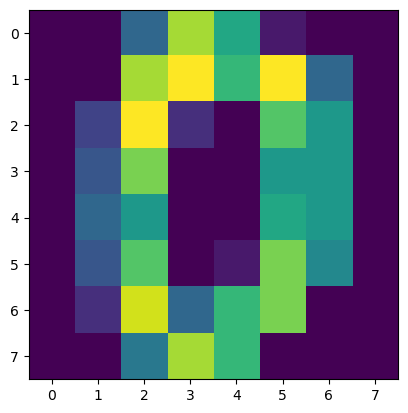

In [2]:
# 1. An example of reducing the number of features
# A compressed MNIST dataset of handwritten digits
# 
# each digit is an 8 by 8 black-white image
# 1.1 the border pixels can be dropped without losing too much information
# 1.2 the importance of each pixel can be shown with a random forest
#     two neighboring pixels are often highly correlated
#     not too much information will be lost if they were merged into a single pixel

X, y = skds.load_digits(return_X_y=True)
plt.imshow(np.reshape(X[:1],(8,8)))

## Problems Of Reducing Dimensionality
- cause some information loss
- make the ML system perform slightly worse even though it will speed up training
- make ML pipelines a bit more complex and thus harder to maintain

## An Unit [Spacelet](https://en.wikipedia.org/wiki/Hypercube) In Spaces Of Different Dimensions
| # of dimensions | spacelet with sides of 1 unit |
|:---:|:---:|
| 0 | point |
| 1 | an unit segment | 
| 2 | an unit square |
| 3 | an unit cube |
| ≥ 4 | hypercubes |

- many things behave very differently in high-dimensional space
   - the longest diagonal in a n-cube is $\sqrt{n}$
   - the [distance d(n)](https://en.wikipedia.org/wiki/Mean_line_segment_length) between two random selected points in n-cube increases when n increases
     - $d(2) \approx 0.52$
     - $d(3) \approx 0.66$
     - $d(1,000,000) \approx 370.79$
     - ∴ high-dimensional datasets are at risk of being very sparse
       - great risk of overfitting
       - new instances will likely be far away from any training instance
   - most points in a high-dimensional hypercube are very close to the border
- one solution to the curse of dimensionality could be to increase the size of the training set
  - but  the number of training instances required to reach a given density grows exponentially with the number of dimensions


# Main Approaches for Dimensionality Reduction
- Two intuitive methods
  - projection and manifold learning

## Projection
- Generally, training instances are not spread out uniformly across all dimensions
  - Many features are almost constant or highly correlated
  - ∴ all training instances lie within a much lower-dimensional subspace of the high-dimensional space

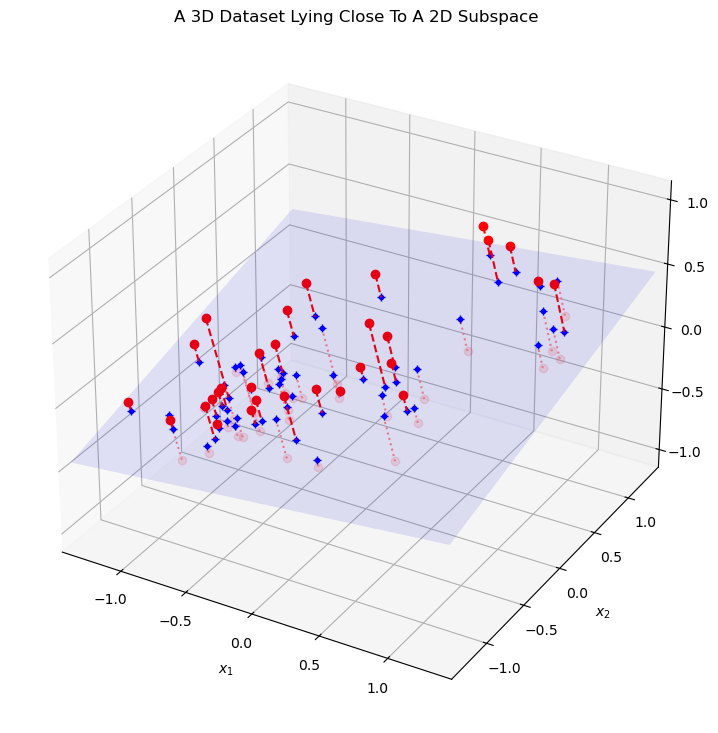

In [3]:
# 1. A 3D dataset lying close to a 2D subspace

from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axis = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axis[0], axis[1], 10),
                     np.linspace(axis[2], axis[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'projection': '3d'})

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.1)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axis):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axis[0:2])
    ax.set_ylim(axis[2:4])
    ax.set_zlim(axis[4:6])

set_xyz_axes(ax, axis)
ax.set_title('A 3D Dataset Lying Close To A 2D Subspace')
ax.set_zticks([-1, -0.5, 0, 0.5, 1]);

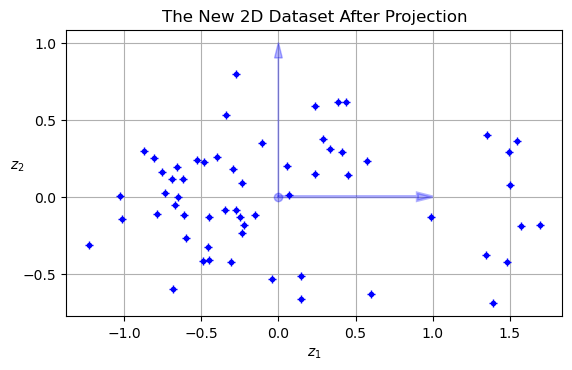

In [4]:
# 2. The new 2D dataset as one projection of the 3D dataset above
fig2, ax2 = plt.subplots(subplot_kw={'aspect': 'equal'})
ax2.plot(X2D[:, 0], X2D[:, 1], "b+")
ax2.plot(X2D[:, 0], X2D[:, 1], "b.")
ax2.plot([0], [0], "bo", alpha=0.3)
ax2.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=2, alpha=0.3)
ax2.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1, alpha=0.3)
ax2.set_xlabel("$z_1$")
ax2.set_yticks([-0.5, 0, 0.5, 1])
ax2.set_ylabel("$z_2$", rotation=0)
ax2.set_axisbelow(True)
ax2.set_title("The New 2D Dataset After Projection")
ax2.grid(True);

## Manifold Learning
- Projection is not suitable to datasets whose subspace may twist and turn
  - unrolling the subspace is preferred

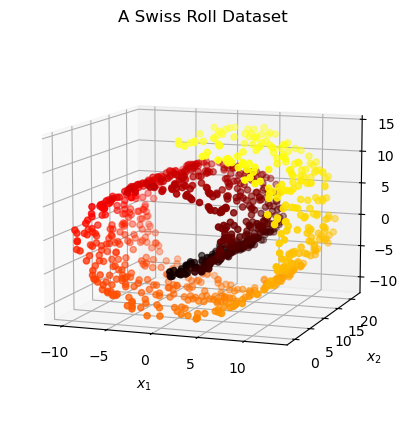

In [5]:
# 1. Swiss roll dataset
from sklearn.datasets import make_swiss_roll
from matplotlib.colors import ListedColormap

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]
fig3, ax3 = plt.subplots(figsize=(6, 5), subplot_kw={'projection':'3d'})

ax3.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax3.view_init(10, -70)
ax3.set_title('A Swiss Roll Dataset')
set_xyz_axes(ax3, axes)

- A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space, such as
  - The Swiss roll locally resembles a 2D plane but rolls in the third dimension
- Generally,  a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane

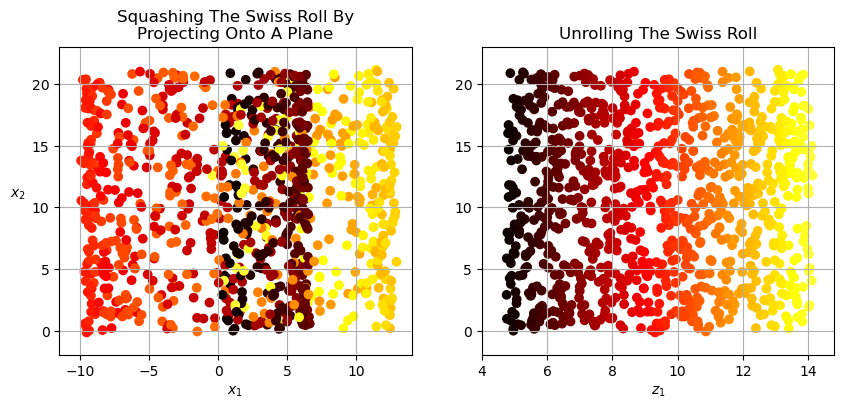

In [6]:
# 2.  unrolling the Swiss roll is preferred than  
#     Squashing by projecting onto a plane

fig4, ax4 = plt.subplots(1, 2, figsize=(10, 4))

# plt.subplot(121)
ax4[0].scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
ax4[0].axis(axes[:4])
ax4[0].set_xlabel("$x_1$")
ax4[0].set_ylabel("$x_2$", labelpad=10, rotation=0)
ax4[0].grid(True)
ax4[0].set_title('Squashing The Swiss Roll By\nProjecting Onto A Plane')

# plt.subplot(122)
ax4[1].scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
ax4[1].axis([4, 14.8, axes[2], axes[3]])
ax4[1].set_xlabel("$z_1$")
ax4[1].set_title('Unrolling The Swiss Roll')
ax4[1].grid(True);

- Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie
  - this is called `manifold learning`
- It relies on two assumptions:
   1. the ` manifold assumption`, also called ` manifold hypothesis`
       - most real-world high-dimensional datasets lie close to a much lower-dimensional manifold
   2. an implicit assumption that the ML task will be simpler if expressed in the lower-dimensional space of the manifold
       - this assumption does not always hold

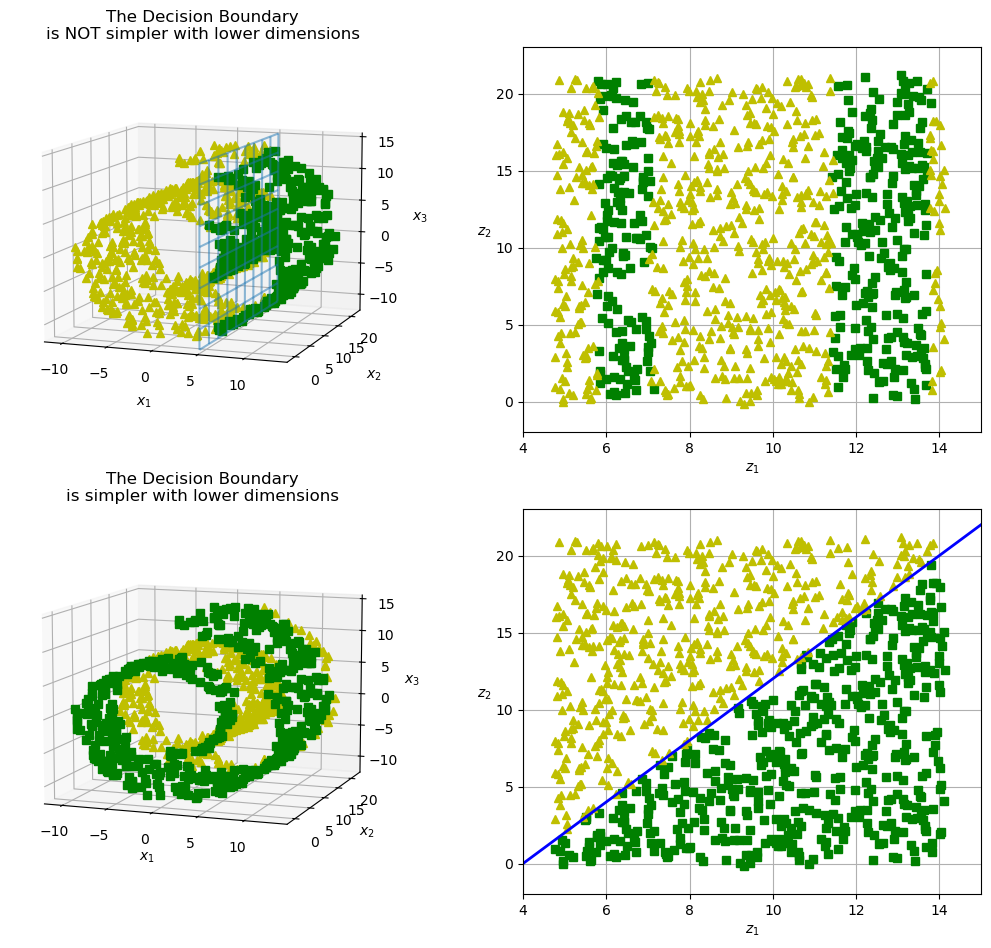

In [7]:
# 3. The implicit assumption above does NOT always hold

axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig5 = plt.figure(figsize=(13, 11))
ax51 = plt.subplot(2, 2, 1, projection='3d')
ax51.view_init(10, -70)
ax51.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax51.plot_wireframe(5, x2, x3, alpha=0.5)
ax51.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax51.set_title('The Decision Boundary\nis NOT simpler with lower dimensions')
set_xyz_axes(ax51, axes)

ax52 = plt.subplot(2, 2, 2)
ax52.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax52.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax52.axis([4, 15, axes[2], axes[3]])
ax52.set_xlabel("$z_1$")
ax52.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax52.grid(True)


positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]


ax53 = plt.subplot(2, 2, 3, projection='3d')
ax53.view_init(10, -70)
ax53.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax53.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax53.xaxis.set_rotate_label(False)
ax53.yaxis.set_rotate_label(False)
ax53.zaxis.set_rotate_label(False)
ax53.set_xlabel("$x_1$", rotation=0)
ax53.set_ylabel("$x_2$", rotation=0)
ax53.set_zlabel("$x_3$", rotation=0)
ax53.set_xlim(axes[0:2])
ax53.set_ylim(axes[2:4])
ax53.set_zlim(axes[4:6])
ax53.set_title('The Decision Boundary\nis simpler with lower dimensions')


ax54 = plt.subplot(2, 2, 4)
ax54.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax54.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax54.plot([4, 15], [0, 22], "b-", linewidth=2)
ax54.axis([4, 15, axes[2], axes[3]])
ax54.set_xlabel("$z_1$")
ax54.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax54.grid(True)

# PCA
- short for `Principal Component Analysis`
- the most popular dimensionality reduction algorithm by far
- It identifies the hyperplane that lies closest to the data, 
  - then projects the data onto it

## Preserving the Variance
- choose the right hyperplane to preserve the most variance of the dataset
  - i.e. lose least information
- The chosen axis minimizes the mean squared distance between the original dataset and its projection

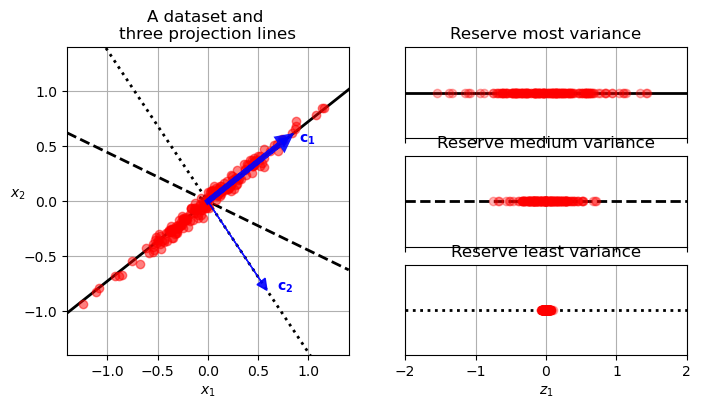

In [8]:
# 1. preserve the variance

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

fig6 = plt.figure(figsize=(8, 4))

ax6l = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
ax6l.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
ax6l.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
ax6l.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
ax6l.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
ax6l.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
ax6l.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
ax6l.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
ax6l.set_xlabel("$x_1$")
ax6l.set_ylabel("$x_2$", rotation=0)
ax6l.axis([-1.4, 1.4, -1.4, 1.4])
ax6l.grid()
ax6l.set_title('A dataset and \nthree projection lines')

ax6r1 = plt.subplot2grid((3, 2), (0, 1))
ax6r1.plot([-2, 2], [0, 0], "k-", linewidth=2)
ax6r1.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
ax6r1.set_yticks([])
ax6r1.set_xticklabels([])
ax6r1.axis([-2, 2, -1, 1])
ax6r1.grid()
ax6r1.set_title('Reserve most variance')

ax6r2 = plt.subplot2grid((3, 2), (1, 1))
ax6r2.plot([-2, 2], [0, 0], "k--", linewidth=2)
ax6r2.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
ax6r2.set_yticks([])
ax6r2.set_xticklabels([])
ax6r2.axis([-2, 2, -1, 1])
ax6r2.grid()
ax6r2.set_title('Reserve medium variance')

ax6r3 = plt.subplot2grid((3, 2), (2, 1))
ax6r3.plot([-2, 2], [0, 0], "k:", linewidth=2)
ax6r3.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
ax6r3.set_yticks([])
ax6r3.axis([-2, 2, -1, 1])
ax6r3.set_xlabel("$z_1$")
ax6r3.grid()
ax6r3.set_title('Reserve least variance');


## Principal Components
- `PCA` identifies the axis that reserves the largest amount of variance in the training set
  - the blue arrow `c1` above
- then it finds a second axis, orthogonal to the first one, that reserves the largest amount of the remaining variance
  - the blue arrow `c2` above
- The iᵗʰ axis is called the iᵗʰ `principal component (PC)` of the dataset
  - the number of PCs equals the number of dimensions in the dataset
- The PCs of a dataset can be found with `singular value decomposition (SVD)`
  - SVD is a standard matrix factorization technique 
  - ${\displaystyle \ \mathbf {M} =\mathbf {U\Sigma V^{T}} }$
  - $\mathbf{V=(c_1,c_2,\cdots,c_m)}$ is the `principal components matrix`

In [9]:
# 1. Find the PCs of dataset X at the beginning of the notebook

# Center the dataset around the origin before PCA
X_centered = X - X.mean(axis=0)

U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]
c3 = Vt[2]
c1,c2,c3

(array([0.67857588, 0.70073508, 0.22023881]),
 array([-0.72817329,  0.6811147 ,  0.07646185]),
 array([-0.09642839, -0.21225719,  0.97244458]))

In [10]:
# 2. construct Σ from s
n, m = X.shape
Σ = np.zeros_like(X_centered)
Σ[:m, :m] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)
diag = np.min([n,m])
Σ[:diag, :diag]

array([[5.93449971, 0.        , 0.        ],
       [0.        , 2.65661127, 0.        ],
       [0.        , 0.        , 2.04831319]])


## Projecting Down to d Dimensions
- With all the PCs, we can reduce the dimensionality of the dataset $\mathbf{X}$ down to d dimensions 
  - by projecting it onto the hyperplane defined by the first d PCs $\mathbf{W_d}$
  - this hyperplane ensures the projection $\mathbf{X_{dproj}}$ will preserve as much variance as possible
  - $\mathbf{X_{dproj} = XW_d}$


In [11]:
# 3. project X to 2D
W2 = Vt[:2].T
X2D = X_centered @ W2
X2D.shape

(60, 2)

In [14]:
W2

array([[ 0.67857588, -0.72817329],
       [ 0.70073508,  0.6811147 ],
       [ 0.22023881,  0.07646185]])


## Using Scikit-Learn
- sklearn PCA takes care of centering the data automatically
  -  its `components_` attribute holds the transpose of $\mathbf{W_d}$
  -  $\mathbf{W_d}$ contains one row for each of the first d PCs


In [22]:
# 1. sklearn PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [23]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])


## Explained Variance Ratio
- indicates the proportion of the dataset’s variance that lies along each principal
component
   - available in attribute `explained_variance_ratio_`


In [24]:
# 1. explained variance ratio
pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(array([0.7578477 , 0.15186921]), 0.9097169067325797)

- 75.78% of the data variance lies along c1
- 15.18% lies along c2
- ∴ 1-75.78%-15.18% = 9.05% lies along c3, which carries little information

## Choosing the Right Number of Dimensions
- choose the number of dimensions that add up to a sufficiently large portion of the variance—say, 95%
  - an exception is visualization, which reduces the dimensionality down to 2 or 3


In [25]:
# 1. preserve 95% of the MNIST training set’s variance
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [26]:
d

154

In [27]:
# 1.1 indicate the ratio of variance to be reserved by
# setting n_components=ratio
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [28]:
# The actual number of components 
pca.n_components_

154

In [29]:
# variance preserved
pca.explained_variance_ratio_.sum()

0.9501960192613034

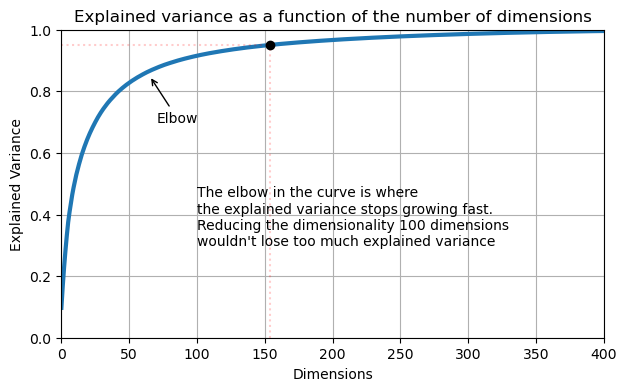

In [39]:
# 2. Explained variance as a function of the number of dimensions
fig7, ax7 = plt.subplots(figsize=(7, 4))
ax7.plot(cumsum, linewidth=3)
ax7.axis([0, 400, 0, 1])
ax7.set_xlabel("Dimensions")
ax7.set_ylabel("Explained Variance")
ax7.plot([d, d], [0, 0.95], "r:", alpha=0.2)
ax7.plot([0, d], [0.95, 0.95], "r:", alpha=0.2)
ax7.plot(d, 0.95, "ko")
ax7.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
ax7.grid(True)
ax7.set_title('Explained variance as a function of the number of dimensions')
ax7.text(100, 0.3, f'The elbow in the curve is where'
              f'\nthe explained variance stops growing fast.'
              f"\nReducing the dimensionality 100 dimensions"
              f"\nwouldn't lose too much explained variance");

In [40]:
# 3. PCA for preprocessing: PCA --> RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [42]:
# best model parameters found
# RandomForestClassifier is a powerful model, 
# it needs just 23 dimensions out of 784 dimensions

X_train.shape, rnd_search.best_params_

((60000, 784),
 {'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23})

In [43]:
# 3.1 PCA followed by a less powerful model SGDClassifier
# Now the SGDClassifier needs 67 dimensions out of 784 dimensions
# this is still a small number compared to the original number of dimension

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [44]:
grid_search.best_params_

{'pca__n_components': 67}


## PCA for Compression
- After dimensionality reduction, the training set takes up much less space
- e.x. the PCA reserves 95% variance of the MNIST dataset needs only 
  - 154 features out of 784 features, i.e. less than 20% of its original size
  - only lost 5% of its variance
- The inverse transformation of the PCA projection can 
  - reconstruct the original dataset from the compressed dataset
  - certainly with `reconstruction errors` due to variance loss
- $\mathbf{X_{reconstructed} = X_{dproj}W_d^T}$

In [53]:
# 1. compress and reconstruct dataset with PCA
pca1 = PCA(0.95)
X_reduced1 = pca1.fit_transform(X_train, y_train)
pca2 = PCA(0.8)
X_reduced2 = pca2.fit_transform(X_train, y_train)

In [55]:
X_recovered1 = pca1.inverse_transform(X_reduced1)
X_recovered2 = pca2.inverse_transform(X_reduced2)

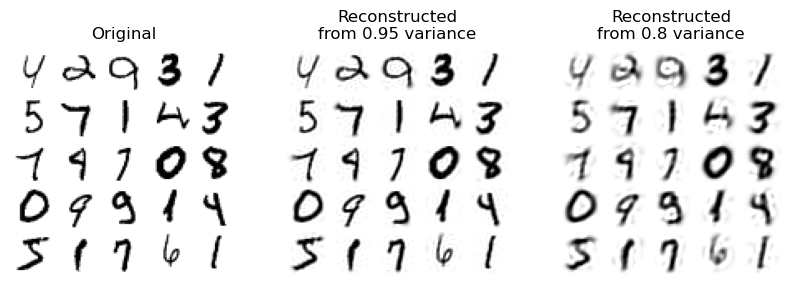

In [57]:
fig8, ax8 = plt.subplots(1, 3, figsize=(10, 4))
for idx, X in enumerate((X_train[::2100], X_recovered1[::2100], X_recovered2[::2100])):
    ax = ax8[idx]
    ax.set_title(["Original", "Reconstructed\nfrom 0.95 variance", "Reconstructed\nfrom 0.8 variance"][idx])
    for row in range(5):
        for col in range(5):
            ax.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            ax.axis([0, 5, 0, 5])
            ax.axis("off")


## Randomized PCA
- enabled by setting the `svd_solver` hyperparameter to "randomized"
- sklearn uses `randomized PCA` to quickly find an approximation of the first d principal components
  - with computational complexity $O(n × d^2) + O(d^3)$ much faster than 
  - the full SVD approach, whose computational complexity is $O(n × m^2) + O(m^3)$
  - given the dataset with n samples and m features
- `svd_solver` is by default set to "auto", sklearn uses the randomized PCA algorithm
  - if max(m, n) > 500 and n_components is an integer smaller than 80% of min(m, n),
  - or else it uses the full SVD approach


In [58]:
# 1. specify the PCA `svd_solver` explicitly
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)


## Incremental PCA
- The preceding implementations of PCA require the whole training set to fit in memory
- Incremental PCA (IPCA) algorithms allow you to 
  - split the training set into mini-batches and
  - feed these in one mini-batch at a time
- This is useful for large training sets and for applying PCA online


In [59]:
# 1. split the MNIST training set into 100 mini-batches
#  feeds them to skLearn’s IncrementalPCA class⁠  to 
#  reduce the dimensionality of the MNIST dataset down to 154 dimensions
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch) # ⚠️: partial_fit instead of fit!

X_reduced = inc_pca.transform(X_train)

In [60]:
# 2. for too large dataset to fit in memory,
# NumPy’s memmap allows you to manipulate a large array stored in a binary file on disk 
# as if it were entirely in memory

# 2.1 copy the MNIST training set to a memory-mapped (memmap) file
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

# 2.2  load the memmap file and use it like a regular NumPy array
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap) # fit is used here since the dataset appears entirely in memory

IncrementalPCA(batch_size=600, n_components=154)

# [Random Projection (RP)](https://scikit-learn.org/stable/modules/random_projection.html)
- The computational complexity of randomized PCA is $O(n × d^2) + O(d^3)$
  - if d and n are large, it is still very slow, then `random project` can help
- RP projects the data to a lower-dimensional space using a `random linear projection`
  - it is very likely to preserve distances fairly well
- This is ensured by the [Johnson-Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma)
  - To keep the squared distance between any two instances by less than ε after the RP to d dimensions, d must satisfy $\displaystyle d \ge \frac{4\log_2 n}{ϵ^2/2-ϵ^3/3}$
- implemented in sklearn `GaussianRandomProjection` and `SparseRandomProjection`
  - `SparseRandomProjection` uses much less memory than `GaussianRandomProjection`

In [9]:
# 1. manual random projection
from sklearn.random_projection import johnson_lindenstrauss_min_dim

n, ε = 1000, 0.1
d = johnson_lindenstrauss_min_dim(n, eps=ε)
d

5920

In [10]:
# 1.1 computed by johnson_lindenstrauss_min_dim
d = int(4 * np.log(n) / (ε ** 2 / 2 - ε ** 3 / 3))
d

5920

In [13]:
m = 10000
np.random.seed(42)
P = np.random.randn(d, m) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(n, m)  # generate a fake dataset
X_reduced = X @ P.T

In [14]:
# 2. use sklearn `GaussianRandomProjection`
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

In [15]:
# 2.1 reconstruct original dataset from the compressed dataset
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [16]:
# 3. performance comparison between Gaussian and Sparse RP

from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
1.12 s ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
976 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
1.03 s ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
440 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# LLE
- short for `Locally linear embedding`
- a nonlinear dimensionality reduction (NLDR) technique
  - not rely on projections, unlike PCA and random projection
- particularly good at unrolling twisted manifolds without too much noise



# Other Dimensionality Reduction Techniques

# References
- [sklearn dataset transformations](https://scikit-learn.org/stable/data_transforms.html)